# Regression

Построение модели линейной регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.

Цель: В этом дз вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без. Снова пройдемся по основным этапам работы с данными и на выходе получим модели, способные предсказывать цены на жильё в AirBnb.
Снова предсказание цены квартиры, но на сей раз съемной :)

In [273]:
import pandas as pd               
import numpy as np               
import matplotlib.pyplot as plt   
import seaborn as sns             

%matplotlib inline

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

In [274]:
import warnings
warnings.filterwarnings("ignore")

# Предобработка данных

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [275]:
df = pd.read_csv('AB_NYC_2019.csv')

In [276]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

In [277]:
df.shape

(48895, 16)

In [278]:
df.dtypes
#посм на типы данных, у нас имеются int, float and object

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [280]:
df.isnull().sum()
# there are nans in name, host_name, last_review, reviews_per_month

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

In [281]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)

In [282]:
# filling NANs with mean
df['reviews_per_month'].fillna(df['reviews_per_month'].mean(), inplace=True)

In [283]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0


After dropping some features, we have:

numerical features: latitude, longitude, price, min_nights, num_of_reviews, reviews_per_month, calculated_host_listing_count, availability_365

categorical features: neigbourhood_group, neighbourhood, room_type

In [284]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.497775,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.280000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.220000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


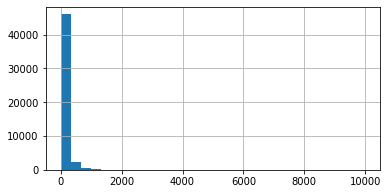

In [285]:
plt.figure(figsize=(6, 3))
df.price.hist(bins=30);

У нашего распределения есть большой хвост. Значит в выборке встречаются квартиры с общей большой стоимостью. Это называется выбросами, к-е могут негативно повлият на модель. Поэтому мы можем сгладить распределение цен - прологарифмировав его. 

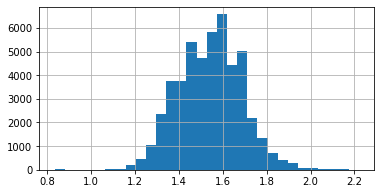

In [287]:
plt.figure(figsize=(6, 3))
df['price'] = np.log(df['price'])
df.price.hist(bins=30);

Теперь нужно посмотреть на распределение других признаков.

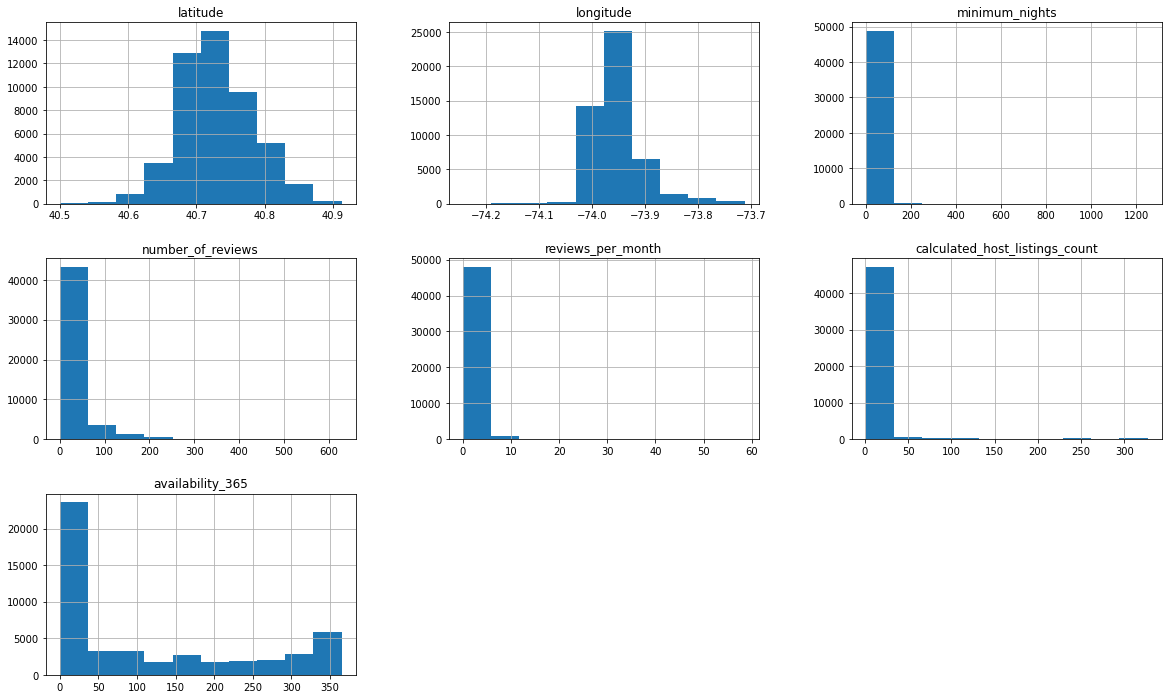

In [288]:
df.drop(['price'], axis=1).hist(figsize=(20,12));
# по распределениям видно, что в данных имеются выбросы.

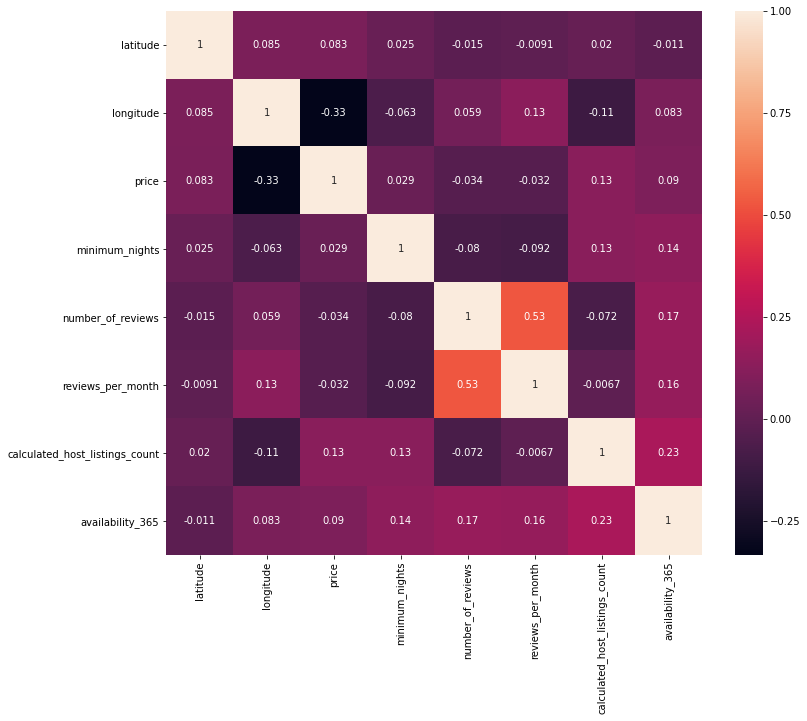

In [289]:
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=True);

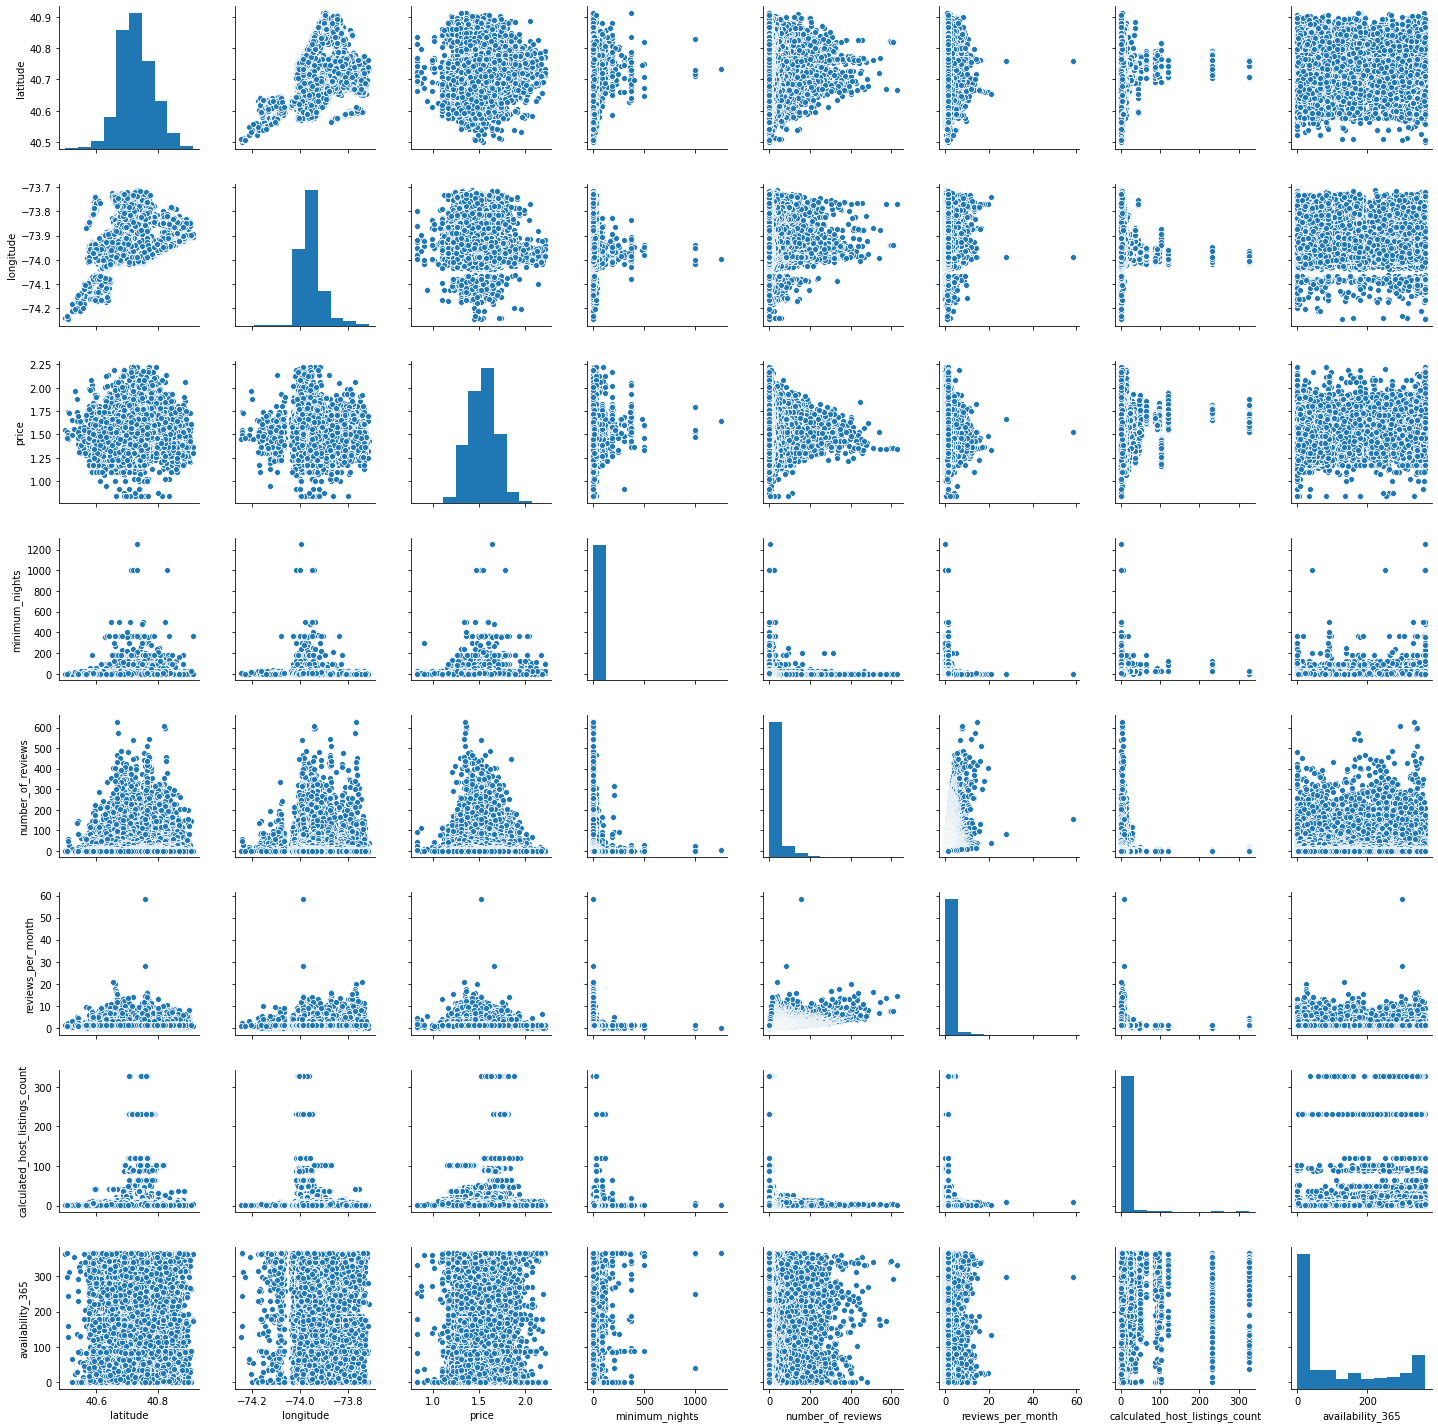

In [290]:
sns.pairplot(df)

In [291]:
df['price'].isnull().sum()

11

In [293]:
df['price']

0        1.610227
1        1.689376
2        1.611563
3        1.501549
4        1.477511
           ...   
48890    1.446565
48891    1.305323
48892    1.557077
48893    1.388126
48894    1.504035
Name: price, Length: 48895, dtype: float64

In [294]:
df['price'].fillna(df['price'].mean(), inplace=True)

In [295]:
df['price'].isnull().sum()

0

### Предобработка категориальных переменных 

In [296]:
# Сделали OHE для категориальной переменной
df_neigh_group = pd.get_dummies(df['neighbourhood_group'], drop_first=True, prefix='neighbourhood_group')
df_neigh = pd.get_dummies(df['neighbourhood'], drop_first=True, prefix='neighbourhood')
df_room = pd.get_dummies(df['room_type'], drop_first=True, prefix='room_type')

In [297]:
# Объединили назад наши таблички
df = pd.concat([df.drop('neighbourhood_group',axis=1),df_neigh_group], axis=1)
df = pd.concat([df.drop('neighbourhood',axis=1),df_neigh], axis=1)
df = pd.concat([df.drop('room_type',axis=1),df_room], axis=1)

df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,1.610227,1,9,0.210000,6,365,1,0,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,1.689376,1,45,0.380000,2,355,0,1,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,1.611563,3,0,1.373221,1,365,0,1,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,1.501549,1,270,4.640000,1,194,1,0,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,1.477511,10,9,0.100000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "center_distance" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

In [298]:
from sklearn.metrics.pairwise import euclidean_distances
center_NYC =[[40.7128, -74.006]]
center_apart = df[['latitude', 'longitude']]
center_distance = euclidean_distances(center_NYC, center_apart).transpose()

In [299]:
df['center_distance'] = center_distance
df = df.drop(['latitude', 'longitude'], axis=1)
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room,center_distance
0,1.610227,1,9,0.210000,6,365,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0.073460
1,1.689376,1,45,0.380000,2,355,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.046481
2,1.611563,3,0,1.373221,1,365,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.115616
3,1.501549,1,270,4.640000,1,194,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.053881
4,1.477511,10,9,0.100000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.105790


In [300]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

In [301]:
to_scale = ['center_distance', 'minimum_nights', 'price', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [302]:
from sklearn.preprocessing import StandardScaler
# объявили скалировщик!
scaler = StandardScaler()
# учим скалировщик скалировать все переменны на трэйне
scaler.fit(df_train[to_scale]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [303]:
df_train_scaler = scaler.transform(df_train[to_scale])
df_test_scaler = scaler.transform(df_test[to_scale])

In [304]:
df_train[to_scale] = df_train_scaler
df_test[to_scale] = df_test_scaler

In [305]:
df_train.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room,center_distance
42083,0.912465,-0.284556,-0.385521,0.971864,0.085295,1.327894,0,1,0,0,...,0,0,0,0,0,0,0,1,0,-0.088603
11322,-0.103791,0.366794,-0.476002,-0.890018,-0.127223,1.517678,0,1,0,0,...,0,0,0,0,0,0,0,1,0,-1.492020
42617,-1.407121,-0.284556,0.021645,3.544646,-0.187943,0.409336,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0.354904
20171,0.918577,-0.238031,-0.430762,-0.842625,-0.157583,-0.858424,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.029682
30260,3.523816,-0.284556,-0.521243,-0.000904,-0.096864,0.204369,1,0,0,0,...,1,0,0,0,0,0,0,0,0,-0.722668


In [306]:
y_train = df_train['price']
y_test = df_test['price']

In [307]:
# y_train.fillna(y_train.mean(), inplace=True)
# y_test.fillna(y_train.mean(), inplace=True)

In [316]:
y_train.isnull().sum()

0

In [308]:
X_train = df_train.drop(['price'], axis=1)
X_test = df_test.drop(['price'], axis=1)

# Метрики качества для регрессии

In [309]:
from sklearn import metrics  # подгружаем метрики

In [310]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [311]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    pass

# Обучение модели

Отложите 30% данных для тестирования и постройте модели RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :)

#### LassoCV 

In [317]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.0003619471663690011


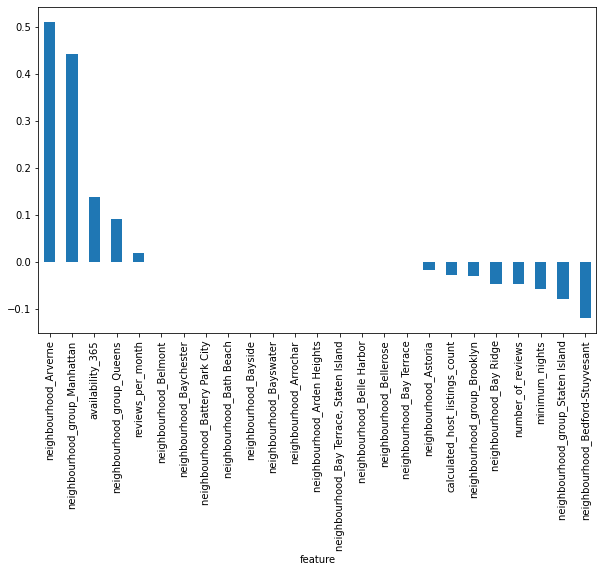

In [318]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns[:25], 
                                  "importance": lasso_cv.coef_[:25]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

In [319]:
print_metrics(y_test, y_pred_lasso_cv)

MAE: 0.8661537692592436
RMSE: 2.9394511786077193
R2: 0.5567099398909687


#### RidgeCV 

In [320]:
from sklearn.linear_model import RidgeCV

In [321]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', ridge_cv.alpha_)

# Сделали прогнозы
y_pred_ridge_cv = ridge_cv.predict(X_test)

Лучшее значение параметра: 1.0


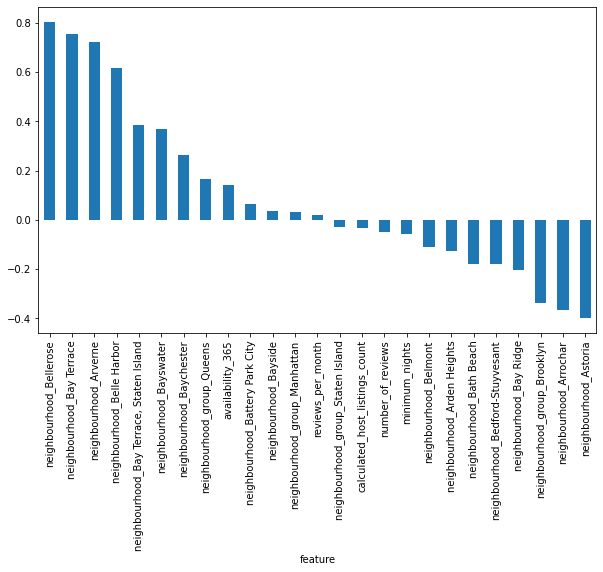

In [322]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns[:25], 
                                  "importance": ridge_cv.coef_[:25]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

In [323]:
print_metrics(y_test, y_pred_ridge_cv)

MAE: 0.8667672381872067
RMSE: 2.9350779690514117
R2: 0.5596360082138396


#### ElasticNetCV 

In [324]:
from sklearn.linear_model import ElasticNetCV

In [325]:
elasticnet_cv = ElasticNetCV(cv=5)
elasticnet_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', elasticnet_cv.alpha_)

# Сделали прогнозы
y_pred_elasticnet_cv = ridge_cv.predict(X_test)

Лучшее значение параметра: 0.0007238943327380015


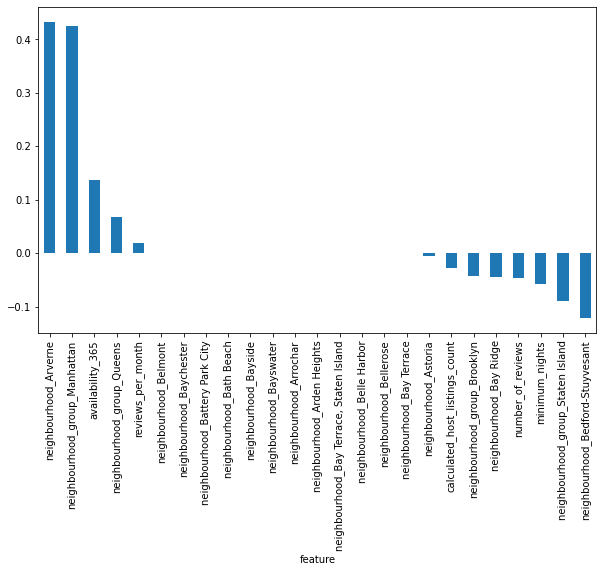

In [326]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns[:25], 
                                  "importance": elasticnet_cv.coef_[:25]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

In [327]:
print_metrics(y_test, y_pred_elasticnet_cv)

MAE: 0.8667672381872067
RMSE: 2.9350779690514117
R2: 0.5596360082138396
